In [18]:
# %pylab inline
# %config InlineBackend.figure_format = 'svg'
import pandas as pd
import numpy as np
import sklearn
import mglearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from pympler import asizeof

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

## generate Test an Training Dataset 

In [2]:
#import training dataset
dataset_train=pd.read_csv('./input/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8',
             's9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names

#add time to failure to train dataset
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']

In [3]:
#import test dataset
dataset_test=pd.read_csv('./input/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names

#import RUL & add test ID
pm_truth=pd.read_csv('./input/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']       #RUL end of Test
pm_truth['id']=pm_truth.index+1 #add Test ID

#generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index() #max cycle for each test ID
rul.columns = ['id', 'max']

#time to failure test data
pm_truth['rtf']=pm_truth['more']+rul['max'] 
pm_truth.drop('more', axis=1, inplace=True)

#add time to failure to test dataset
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left') 
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle'] 
dataset_test.drop('rtf', axis=1, inplace=True)

In [4]:
#add label to predict
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda y: 1 if y <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda y: 1 if y <= period else 0)

## feature scaling

In [5]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'ttf']

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

In [6]:
df_train.head()
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.393352,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.390582,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.387812,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.385042,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.382271,0


## feature selection 

In [7]:
# #Show all features
# import matplotlib.pyplot as plt

# plt.subplot(641)
# sns.distplot(df_train['setting1'])
# plt.title('setting1')

# plt.subplot(642)
# sns.distplot(df_train['setting2'])
# plt.title('setting2')

# plt.subplot(643)
# sns.distplot(df_train['setting3'])
# plt.title('setting3')

# plt.subplot(644)
# sns.distplot(df_train['s1'])
# plt.title('Sensor 1')

# plt.subplot(645)
# sns.distplot(df_train['s2'])
# plt.title('Sensor 2')

# plt.subplot(646)
# sns.distplot(df_train['s3'])
# plt.title('Sensor 3')

# plt.subplot(647)
# sns.distplot(df_train['s4'])
# plt.title('Sensor 4')

# plt.subplot(648)
# sns.distplot(df_train['s5'])
# plt.title('Sensor 5')

# plt.subplot(649)
# sns.distplot(df_train['s6'])
# plt.title('Sensor 6')

# plt.subplot(6,4,10)
# sns.distplot(df_train['s7'])
# plt.title('Sensor 7')

# plt.subplot(6,4,11)
# sns.distplot(df_train['s8'])
# plt.title('Sensor 8')

# plt.subplot(6,4,12)
# sns.distplot(df_train['s9'])
# plt.title('Sensor 9')

# plt.subplot(6,4,13)
# sns.distplot(df_train['s10'])
# plt.title('Sensor 10')

# plt.subplot(6,4,14)
# sns.distplot(df_train['s11'])
# plt.title('Sensor 11')

# plt.subplot(6,4,15)
# sns.distplot(df_train['s12'])
# plt.title('Sensor 12')

# plt.subplot(6,4,16)
# sns.distplot(df_train['s13'])
# plt.title('Sensor 13')

# plt.subplot(6,4,17)
# sns.distplot(df_train['s14'])
# plt.title('Sensor 14')

# plt.subplot(6,4,18)
# sns.distplot(df_train['s15'])
# plt.title('Sensor 15')

# plt.subplot(6,4,19)
# sns.distplot(df_train['s16'])
# plt.title('Sensor 16')

# plt.subplot(6,4,20)
# sns.distplot(df_train['s17'])
# plt.title('Sensor 17')

# plt.subplot(6,4,21)
# sns.distplot(df_train['s18'])
# plt.title('Sensor 18')

# plt.subplot(6,4,22)
# sns.distplot(df_train['s19'])
# plt.title('Sensor 19')

# plt.subplot(6,4,23)
# sns.distplot(df_train['s20'])
# plt.title('Sensor 20')

# plt.subplot(6,4,24)
# sns.distplot(df_train['s21'])
# plt.title('Sensor 21')

# plt.tight_layout(pad=1, w_pad=1, h_pad=1)

# df_train.head()

In [8]:
#drop Sensors with only one value
features_select=['setting1', 'setting2','s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11',
                   's12', 's13', 's14', 's15', 's17', 's20', 's21']

#to predict classification
target_col_name='label_bc'

#to predict with regression
target_col_name_reg = 'ttf'

# generate X_train
X_train = np.array(df_train[features_select])

# generate y_train classification
Y_train= df_train[target_col_name]

#generate y_train regression
Y_train_reg = df_train[target_col_name_reg]

# generate X_test
X_test = np.array(df_test[features_select])

# generate y_test classification
Y_test = df_test[target_col_name]

#generate y_test regression
Y_test_reg = df_test[target_col_name_reg]



## LSTM (long short term Memory)

In [9]:
#generate training dataset for LMST
sequence = 50
X_train_LSTM = np.zeros((X_train.shape[0]-sequence,sequence, X_train.shape[1])) #start matrix
id_train = np.reshape(np.array(dataset_train['id']),((X_train.shape[0],1)))
X_train_help = np.hstack((id_train, X_train)) #add id in trainings set

for i in range (sequence, X_train.shape[0]-1):          # row (cycle)
    for k in range (0, sequence -1):                    # column (old sensor values)
           for j in range (0, X_train_help.shape[1]-1): # column sekound dimension (sensor values)
                if X_train_help[i-k, 0] - X_train_help[i, 0] >= 0:
                    X_train_LSTM[i-sequence, k, j] = X_train_help[i-k, j+1] #overwrite values

#generate Y train for LMST with same shape
Y_train_LSTM = np.zeros((Y_train.shape[0] - sequence))

for i in range (sequence, Y_train.shape[0]-1): 
    Y_train_LSTM [i-sequence] = Y_train [i]

#generate testing dataset for LMST
X_test_LSTM = np.zeros((X_test.shape[0], sequence, X_test.shape[1]))
id_test = np.reshape(np.array(dataset_test['id']),((X_test.shape[0],1)))
X_test_help = np.hstack((id_test, X_test)) #add id in test set

for i in range (0, X_test.shape[0]-1):                 # row (cycle)
    for k in range (0, sequence -1):                   # column (old sensor values)
           for j in range (0, X_test_help.shape[1]-1):        # column sekound dimension (sensor values)
                if i - k >= 0:
                    if X_test_help[i-k, 0] - X_test_help[i, 0] >= 0:
                        X_test_LSTM[i, k, j] = X_test_help[i-k, j+1] #overwrite values
                        
np.shape(X_test_LSTM)

(13096, 50, 17)

In [10]:
nb_features =X_train_LSTM.shape[2]
timestamp=sequence

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           47200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 77,451
Trainable params: 77,451
Non-trainable params: 0
_________________________________________________________________


In [11]:
# fit the network
start_LSTM = timer()
model.fit(X_train_LSTM, Y_train_LSTM, epochs=20, batch_size=200, validation_split=0.05, verbose=1)
          #callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
end_LSTM = timer()
time_LSTM = end_LSTM - start_LSTM
print('time for training of LSTM Model: ' + str(round(time_LSTM,2))+ ' s')
LSTM_size = asizeof.asizeof(model)
print('Memory allocation of LSTM objekt: ' + str(round(LSTM_size,2))+ ' MB')

Epoch 1/20
98/98 [==============================] - 13s 135ms/step - loss: 0.2689 - accuracy: 0.9031 - val_loss: 0.2247 - val_accuracy: 0.9029
Epoch 2/20
98/98 [==============================] - 13s 130ms/step - loss: 0.1254 - accuracy: 0.9491 - val_loss: 0.1268 - val_accuracy: 0.9456
Epoch 3/20
98/98 [==============================] - 13s 129ms/step - loss: 0.1087 - accuracy: 0.9538 - val_loss: 0.1224 - val_accuracy: 0.9447
Epoch 4/20
98/98 [==============================] - 13s 129ms/step - loss: 0.1039 - accuracy: 0.9558 - val_loss: 0.1012 - val_accuracy: 0.9495
Epoch 5/20
98/98 [==============================] - 13s 129ms/step - loss: 0.1199 - accuracy: 0.9491 - val_loss: 0.1389 - val_accuracy: 0.9476
Epoch 6/20
98/98 [==============================] - 13s 129ms/step - loss: 0.1042 - accuracy: 0.9561 - val_loss: 0.1052 - val_accuracy: 0.9476
Epoch 7/20
98/98 [==============================] - 13s 130ms/step - loss: 0.1020 - accuracy: 0.9566 - val_loss: 0.1079 - val_accuracy: 0.9495

In [12]:
# training metrics
scores = model.evaluate(X_train_LSTM, Y_train_LSTM, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

103/103 [==============================] - 4s 42ms/step - loss: 0.0417 - accuracy: 0.9816
Accurracy: 0.9815849661827087


In [13]:
Y_pred_LSTM=model.predict_classes(X_test_LSTM)
# Y_pred_LSTM=np.argmax(model.predict(X_test_LSTM))

from sklearn.metrics import confusion_matrix,accuracy_score

confusion_matrix_LSTM = confusion_matrix(Y_test, Y_pred_LSTM)
accuracy_LSTM = (confusion_matrix_LSTM[0,0]+confusion_matrix_LSTM[1,1])/(confusion_matrix_LSTM[0,0]+confusion_matrix_LSTM[0,1]+confusion_matrix_LSTM[1,0]+confusion_matrix_LSTM[1,1])
print('Accuracy of model on test data: ',accuracy_LSTM)
print('Confusion Matrix: \n',confusion_matrix_LSTM)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy of model on test data:  0.9915241295051924
Confusion Matrix: 
 [[12734    30]
 [   81   251]]


## LSTM regession 

In [14]:
Y_train_LSTM_reg = np.zeros((Y_train_reg.shape[0] - sequence))

for i in range (sequence, Y_train_reg.shape[0]-1): 
    Y_train_LSTM_reg [i-sequence] = Y_train_reg [i]
    
# fit the network
model.fit(X_train_LSTM, Y_train_LSTM_reg, epochs=20, batch_size=200, validation_split=0.05, verbose=1)
          #callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

NameError: name 'zeros' is not defined

In [15]:
Y_pred_LSTM_reg=model.predict(X_test_LSTM)

scores_reg = model.evaluate(X_train_LSTM, Y_train_LSTM_reg, verbose=1, batch_size=200)

103/103 [==============================] - 4s 42ms/step - loss: 0.5316 - accuracy: 0.0049


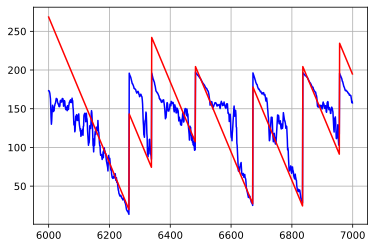

In [16]:
t = arange(0, Y_pred_LSTM_reg.shape[0])

#Ausschnitt
a = 6000
e = 7000

plot(t[a:e], Y_pred_LSTM_reg[a:e]*340, 'b')
plot(t[a:e], Y_test_reg[a:e]*340, 'r')
grid(True)

## RUL LMST

In [17]:
#remain useful Lifetime prediction
Y_pred_LSTM_id = np.hstack((id_test, np.reshape(np.array(Y_pred_LSTM),((Y_test.shape[0],1))))) #add id to prediction
rul_pred_LSTM = np.zeros((Y_pred_LSTM_id.shape[0]))
rul_akt = period #Remain useful lifetime start
for i in range (1, Y_pred_LSTM_id.shape[0]-1):
    if Y_pred_LSTM_id[i, 0] > Y_pred_LSTM_id[i-1,0] :
        rul_akt = period
    else:
        rul_akt = rul_akt - Y_pred_LSTM_id[i, 1]
    rul_pred_LSTM[i] = rul_akt
        
#remain useful Lifetime real
Y_test_id = np.hstack((id_test, np.reshape(np.array(Y_test),((Y_test.shape[0],1)))))
rul_real = np.zeros((Y_test_id.shape[0]))
rul_akt = period #Remain useful lifetime start
for i in range (1, Y_test_id.shape[0]-1):
    if Y_test_id[i, 0] > Y_test_id[i-1,0] :
        rul_akt = period
    else:
        rul_akt = rul_akt - Y_test_id[i, 1]
    rul_real[i] = rul_akt

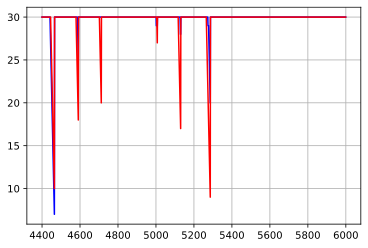

In [18]:
t = arange(0, Y_pred_LSTM.shape[0])

#Ausschnitt
a = 4400
e = 6000

plot(t[a:e], rul_pred_LSTM[a:e], 'b')
#plot(t[a:e], (prediction[a:e] - Y_test[a:e])) #Falsch Positiv = 1, Flasch Negativ = -1
plot(t[a:e], rul_real[a:e], 'r')
grid(True)

# KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifiers

#find the best number of neighbours
accuracy_N = np.zeros(50)
for N in range (1, accuracy_N.shape[0]):
    knn = KNeighborsClassifier(n_neighbors = N)
    knn.fit(X_train, Y_train)
    accuracy_N [N] = knn.score(X_test, Y_test)

0.986484422724496


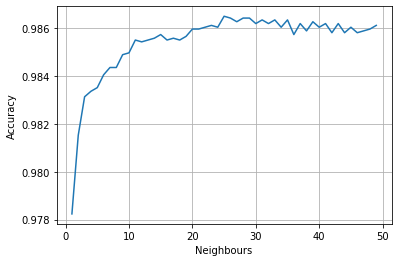

In [19]:
# Anzahl Nachbarn "N"
N = np.arange(0, accuracy_N.shape[0])
plt.plot(N[1:50], accuracy_N[1:50])
plt.xlabel('Neighbours')
plt.ylabel('Accuracy')
print(accuracy_N.max())
plt.grid(True)

In [21]:
#KNN model with N = 25
knn = KNeighborsClassifier(n_neighbors = 25)
start_knn = timer()
knn.fit(X_train, Y_train)
end_knn = timer()
time_knn = end_knn - start_knn
print('time for training of knn Model: ' + str(round(time_knn,2))+ ' s')
_test)
print('Confusion Matrix: \n',confusion_matrix_KNN)
print('accuracy:', accuracy_KNN)
print('Memory allocation of knn objekt: ' + str(round(knn_size,2))+ ' MB')

time for training of knn Model: 0.13 s
Memory allocation of knn objekt: 2.89 MB


In [24]:
Y_pred_KNN = knn.predict(X_test)
confusion_matrix_KNN = confusion_matrix(Y_test, Y_pred_KNN)
accuracy_KNN = knn.score(X_test, Y_test)
print('Confusion Matrix: \n',confusion_matrix_KNN)
print('accuracy:', accuracy_KNN)

Confusion Matrix: 
 [[12729    35]
 [  142   190]]
accuracy: 0.986484422724496


## RUL KNN

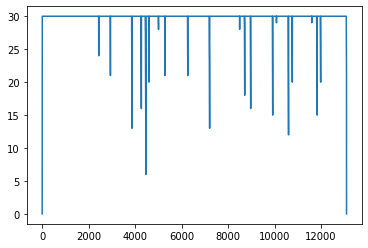

In [26]:
#remain useful Lifetime prediction
Y_pred_KNN_id = np.hstack((id_test, np.reshape(np.array(Y_pred_KNN),((Y_test.shape[0],1))))) #add id to prediction
rul_pred_KNN = np.zeros((Y_pred_KNN_id.shape[0]))
rul_akt = period #Remain useful lifetime start
for i in range (1, Y_pred_KNN_id.shape[0]-1):
    if Y_pred_KNN_id[i, 0] > Y_pred_KNN_id[i-1,0] :
        rul_akt = period
    else:
        rul_akt = rul_akt - Y_pred_KNN_id[i, 1]
    rul_pred_KNN[i] = rul_akt

plt.plot(rul_pred_KNN)

# SVM

In [37]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# find the best factor "C"
accuracy_C = zeros(50)
for i in range (1, accuracy_C.shape[0]):
    logreg = LogisticRegression(C=i).fit(X_train, Y_train) # C: Unregelmädigkeitsfaktor
    accuracy_C [i] = logreg.score(X_test, Y_test)

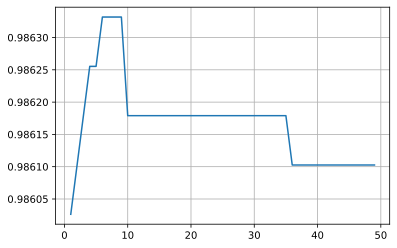

In [40]:
# plot C
C = arange(0, accuracy_C.shape[0])
plot(C[1:50], accuracy_C[1:50])
grid(True)

In [41]:
# for C = 8:
start_SVM = timer()
logreg = LogisticRegression(C=8).fit(X_train, Y_train)
end_SVM = timer()
time_SVM = end_SVM - start_SVM
print('time for training of SVM Model: ' + str(round(time_SVM,2))+ ' s')
SVM_size = asizeof.asizeof(logreg)
print('Memory allocation of SMV objekt: ' + str(round(SVM_size,2))+ ' MB')

time for training of SVM Model: 0.16 s
Memory allocation of SMV objekt: 2720 MB


In [42]:
Y_pred_SVM = logreg.predict(X_test)
confusion_matrix_SVM = confusion_matrix(Y_test, Y_pred_SVM)
accuracy_SVM = logreg.score(X_test, Y_test)
print('Confusion Matrix: \n',confusion_matrix_SVM)
print('accuracy:', accuracy_SVM)

Confusion Matrix: 
 [[12719    45]
 [  134   198]]
accuracy: 0.9863317043372022


## RUL SVM 

In [43]:
#remain useful Lifetime prediction
Y_pred_SVM_id = hstack((id_test, reshape(np.array(Y_pred_SVM),((Y_test.shape[0],1))))) #add id to prediction
rul_pred_SVM = zeros((Y_pred_SVM_id.shape[0]))
rul_akt = period #Remain useful lifetime start
for i in range (1, Y_pred_SVM_id.shape[0]-1):
    if Y_pred_SVM_id[i, 0] > Y_pred_SVM_id[i-1,0] :
        rul_akt = period
    else:
        rul_akt = rul_akt - Y_pred_SVM_id[i, 1]
    rul_pred_SVM[i] = rul_akt

# Comparisson 

## RUL 

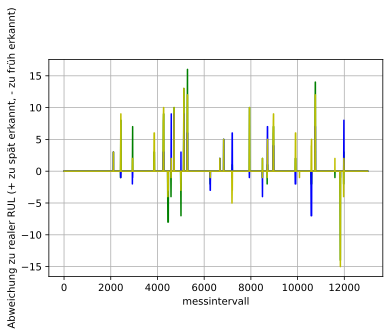

In [45]:
t = arange(0, Y_pred_LSTM.shape[0])

#Ausschnitt
a = 0
e = 13000

plot(t[a:e], rul_pred_SVM[a:e] - rul_real[a:e], 'g')
plot(t[a:e], rul_pred_LSTM[a:e] - rul_real[a:e], 'b')
#plot(t[a:e], rul_real[a:e], 'r')
plot(t[a:e], rul_pred_KNN[a:e] - rul_real[a:e], 'y')
xlabel('messintervall')
ylabel('Abweichung zu realer RUL (+ zu spät erkannt, - zu früh erkannt)')
grid(True)